In [1]:
#import all the libraries

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Dropout,Conv2D 
from tensorflow.keras.layers import MaxPooling2D,Flatten,Dropout
from tensorflow.keras.layers import BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
import SimpleITK as sitk
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random
import time
import datetime

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [2]:
#naming the model

NAME = 'Pneumonia_Xception'

#creating log for running tensorboard

tensorboard = TensorBoard(log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [3]:
#define size of images

image_size = 299

#define the labels

labels = ['1_NORMAL', '2_BACTERIA','3_VIRUS']

Image name = person1000_bacteria_2931.jpeg
The dimensions are 760 pixels height and 1152 pixels width
The maximum pixel value is 255.0000
The minimum pixel value is 0.0000
The mean value of the pixels is 114.5373
The standard deviation is 56.2341


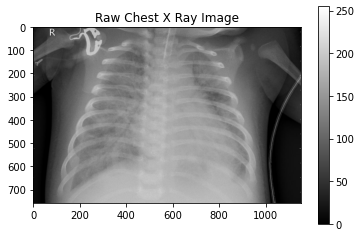

In [4]:
#load a single image from the bacteria folder

def load_image(path):
    for img in os.listdir(bacteria_path):
        print('Image name =',img)
        image = cv.imread(os.path.join(bacteria_path, img))
        break
        
    return image

# Investigate a single image

bacteria_path = 'D:/Kaggle datasets/chest_xray_tf/train/2_BACTERIA/'

image = load_image(bacteria_path)
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions are {image.shape[0]} pixels height and {image.shape[1]} pixels width")
print(f"The maximum pixel value is {image.max():.4f}")
print(f"The minimum pixel value is {image.min():.4f}")
print(f"The mean value of the pixels is {image.mean():.4f}")
print(f"The standard deviation is {image.std():.4f}")

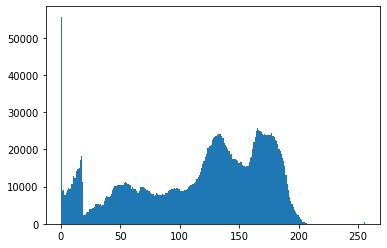

In [5]:
# plot a histogram
plt.hist(image.ravel(),256,[0,256]) 
plt.show()

In [6]:
#create a function to load the image and labels

def create_training_data(paths):
    
    images = []
    
    for label in labels:
        dir = os.path.join(paths,label)
        class_num = labels.index(label)
        
        for image in os.listdir(dir):
            image_read = cv.imread(os.path.join(dir,image))
            image_resized = cv.resize(image_read,(image_size,image_size),cv.IMREAD_GRAYSCALE)
            images.append([image_resized,class_num])
            
    return np.array(images)

In [7]:
#create the training and validation set

train = create_training_data('D:/Kaggle datasets/chest_xray_tf/train')
val = create_training_data('D:/Kaggle datasets/chest_xray_tf/val')

print(f'Shape of the training images = {train.shape}')
print(f'Shape of the validation images = {val.shape}')

C:\Users\asarkar.NATICK-NT\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


Shape of the training images = (5706, 2)
Shape of the validation images = (150, 2)


1_NORMAL


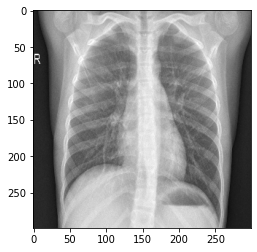

In [8]:
#display an image

plt.imshow(train[1][0], cmap='gray')
print(labels[train[1][1]])

In [9]:
#load train images and labels in X and y

X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)
    
X1= np.array(X)
y1 = np.array(y)
y1 = np.expand_dims(y1, axis=1)

#Load validation images and labels in X_val and y_val
    
X_val = []
y_val = []

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)
    
X_val= np.array(X_val)
y_val1 = np.array(y_val)
y_val = np.expand_dims(y_val1, axis=1)

print(X1.shape)
print(y1.shape)
print(X_val.shape)
print(y_val.shape)

(5706, 299, 299, 3)
(5706, 1)
(150, 299, 299, 3)
(150, 1)


In [10]:
#split train images into train and test
#20% images will be used for testing

X_train, X_test, y_train, y_test = train_test_split(X1, 
                                                    y1, 
                                                    test_size=0.2,
                                                    random_state = 32, 
                                                    stratify=y1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4564, 299, 299, 3)
(1142, 299, 299, 3)
(4564, 1)
(1142, 1)


Number of Normal images = 1226
Number of Bacteria images = 2184
Number of Virus images = 1154


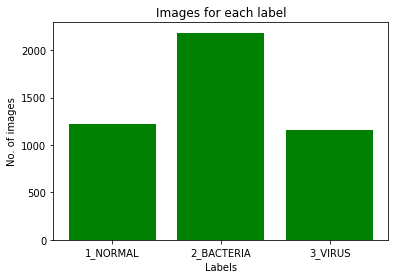

In [11]:
# checking the number of images of each class

a = 0
b = 0
c = 0

for label in y_train:
    if label == 0:
        a += 1
    if label == 1:
        b += 1
    if label == 2:
        c += 1
        
print (f'Number of Normal images = {a}')
print (f'Number of Bacteria images = {b}')
print (f'Number of Virus images = {c}')

# plotting the data

xe = [i for i, _ in enumerate(labels)]

numbers = [a,b,c]
plt.bar(xe,numbers,color = 'green')
plt.xlabel("Labels")
plt.ylabel("No. of images")
plt.title("Images for each label")

plt.xticks(xe, labels)

plt.show()

In [12]:
# find the difference from the majority class

difference_normal = b-a
difference_virus = b-c

print(difference_normal)
print(difference_virus)

958
1030


In [13]:
# artificial data augmentation of the minority classes

def rotate_images(image, scale =1.0, h=299, w = 299):
    
    center = (h/2,w/2)
    
    angle = random.randint(-25,25)
    M = cv.getRotationMatrix2D(center, angle, scale)
    rotated = cv.warpAffine(image, M, (h,w))
    return rotated

def flip (image):
    
    flipped = np.fliplr(image)
    return flipped

def translation (image):
    
    x= random.randint(-50,50)
    y = random.randint(-50,50)
    rows,cols,z = image.shape
    M = np.float32([[1,0,x],[0,1,y]])
    translate = cv.warpAffine(image,M,(cols,rows))
    
    return translate

# function to apply the above augmentations at random

def apply_aug (image):
    
    number = random.randint(1,4)
    
    if number == 1:
        image= rotate_images(image, scale =1.0, h=299, w = 299)
            
    if number == 2:
        image= flip(image)
                
    if number ==3:
        image= translation(image)
    
    return image

In [14]:
# apply the augmentations to oversample the images

def oversample_images (difference_normal,difference_virus, X_train, y_train):
    
    normal_counter = 0
    virus_counter= 0
    new_normal = []
    new_virus = []
    label_normal = []
    label_virus = []
    
    for i,item in enumerate (X_train):
        
        if y_train[i] == 0 and normal_counter < difference_normal:
            
            image = apply_aug(item)
            
            normal_counter = normal_counter+1
            label = 0
            
            new_normal.append(image)
            label_normal.append(label)
            
            
        if y_train[i] == 2 and virus_counter < difference_virus:
            
            image = apply_aug(item)
            
            virus_counter = virus_counter+1
            label =2
            
            new_virus.append(image)
            label_virus.append(label)
            
    
    new_normal = np.array(new_normal)
    label_normal = np.array(label_normal)
    new_virus= np.array(new_virus)
    label_virus = np.array(label_virus)
    
    return new_normal, label_normal, new_virus, label_virus

n_images,n_labels,v_images,v_labels =oversample_images(difference_normal,
                                                       difference_virus,
                                                       X_train,y_train)
print(n_images.shape)
print(n_labels.shape)
print(v_images.shape)
print(v_labels.shape)

(958, 299, 299, 3)
(958,)
(1030, 299, 299, 3)
(1030,)


Display Random Images


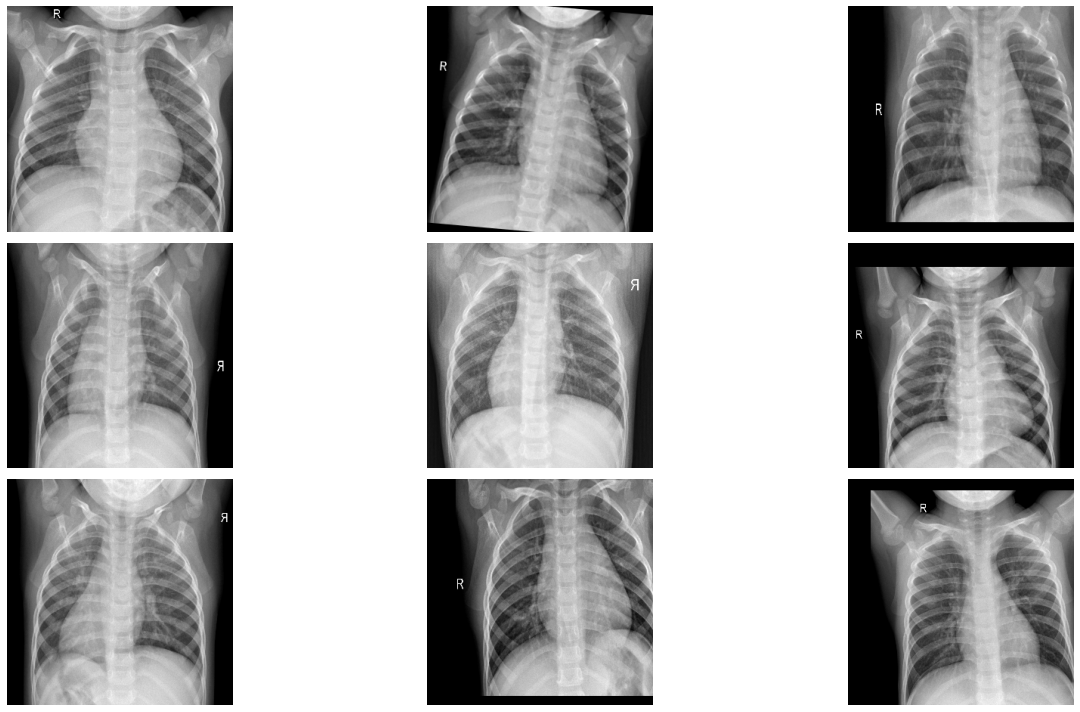

In [15]:
# Extract 9 random images
print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

for i in range(9):
    num = random.randint(0,len(n_images)-1)
    plt.subplot(3, 3, i + 1)
    
    plt.imshow(n_images[num],cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

Display Random Images


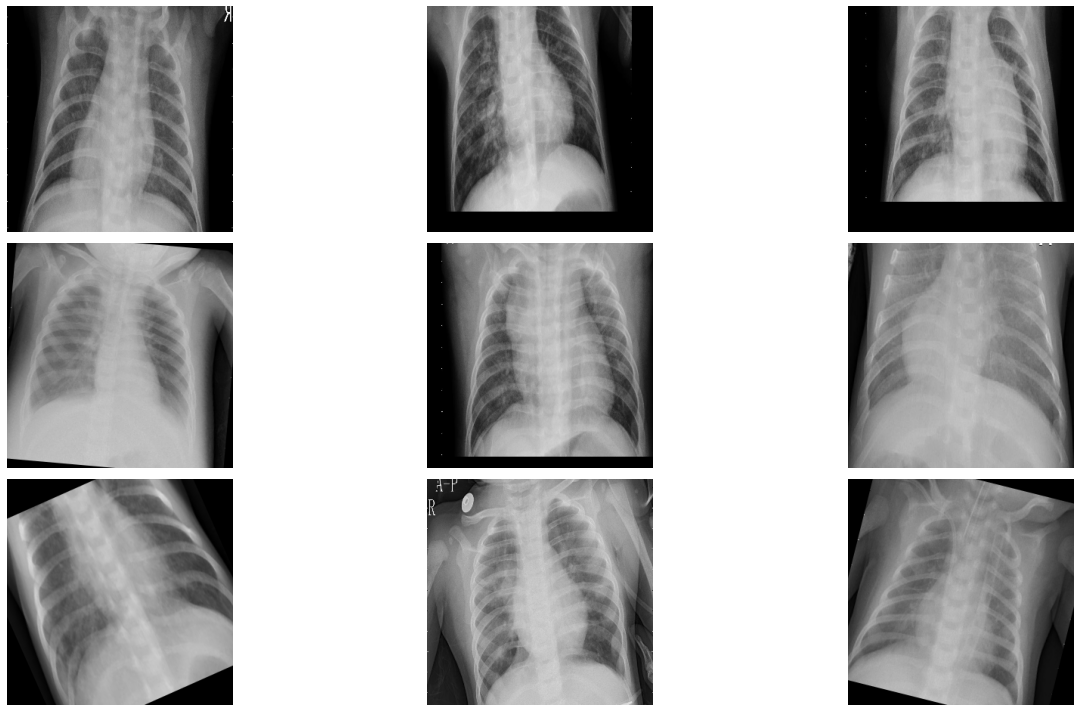

In [16]:
# Displays 9 generated viral images 
# Extract 9 random images
print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

for i in range(9):
    num = random.randint(0,len(v_images)-1)
    plt.subplot(3, 3, i + 1)
    
    plt.imshow(v_images[num],cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

In [17]:
#merge the new images with the original images

new_labels = np.append(n_labels,v_labels)
y_new_labels = np.expand_dims(new_labels, axis=1)
x_new_images = np.append(n_images,v_images,axis=0)

X_train = np.append(X_train,x_new_images,axis=0)
y_train = np.append(y_train,y_new_labels)

print(X_train.shape)
print(y_train.shape)

(6552, 299, 299, 3)
(6552,)


Number of Normal images = 2184
Number of Bacteria images =  2184
Number of Virus images = 2184


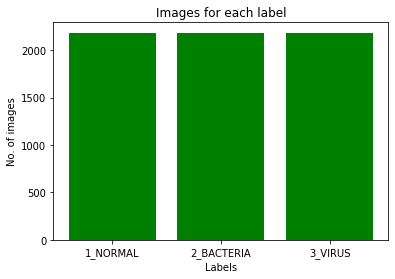

In [18]:
#training set after oversampling

bacteria_new=0
virus_new=0
normal_new =0

for i in y_train:
    
    if i==0:
        normal_new = normal_new+1
    elif i==1 :
        bacteria_new = bacteria_new+1
    else:
        virus_new=virus_new+1    
        
print ('Number of Normal images =',normal_new)
print ('Number of Bacteria images = ',bacteria_new)
print ('Number of Virus images =',virus_new)

# plotting the data

xe = [i for i, _ in enumerate(labels)]

numbers = [normal_new, bacteria_new, virus_new]
plt.bar(xe,numbers,color = 'green')
plt.xlabel("Labels")
plt.ylabel("No. of images")
plt.title("Images for each label")

plt.xticks(xe, labels)

plt.show()

In [19]:
def get_train_generator(X_train,y_train, batch_size = 4, shuffle = True, seed = 1):
      
    print("getting train generator...") 
    # normalize and augment images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        rotation_range = 15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode="nearest",
        cval=0.0,
        rescale = 0.2)
    
    generator = image_generator.flow(
            X_train,
            y=y_train,
            shuffle=shuffle,
            batch_size=batch_size,
            seed=seed
            )
    
    return generator

def get_test_val_generator(X_train,y_train,X_test,y_test,X_val,y_val,
                      batch_size=4, seed=1, sample_size=100):
    
    # use sample to fit mean and std for test set generator
    
    raw_train_generator = ImageDataGenerator().flow(
        X_train,y_train, 
        batch_size=sample_size, 
        shuffle=True)
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)
    
    # get test generator
    test_generator = image_generator.flow(
            X_test,
            y=y_test,
            batch_size=batch_size,
            shuffle=False,
            seed=seed)
    
    #get validation generator
    val_generator = image_generator.flow(
            X_val,
            y=y_val,
            batch_size=batch_size,
            shuffle=False,
            seed=seed)
    
    return test_generator,val_generator


#create the train, test and validation generator  

train_generator = get_train_generator(X_train,y_train) 

test_generator,valid_generator = get_test_val_generator(X_train,y_train,
                                                        X_test,y_test,
                                                        X_val,y_val)

getting train generator...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Display Random Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


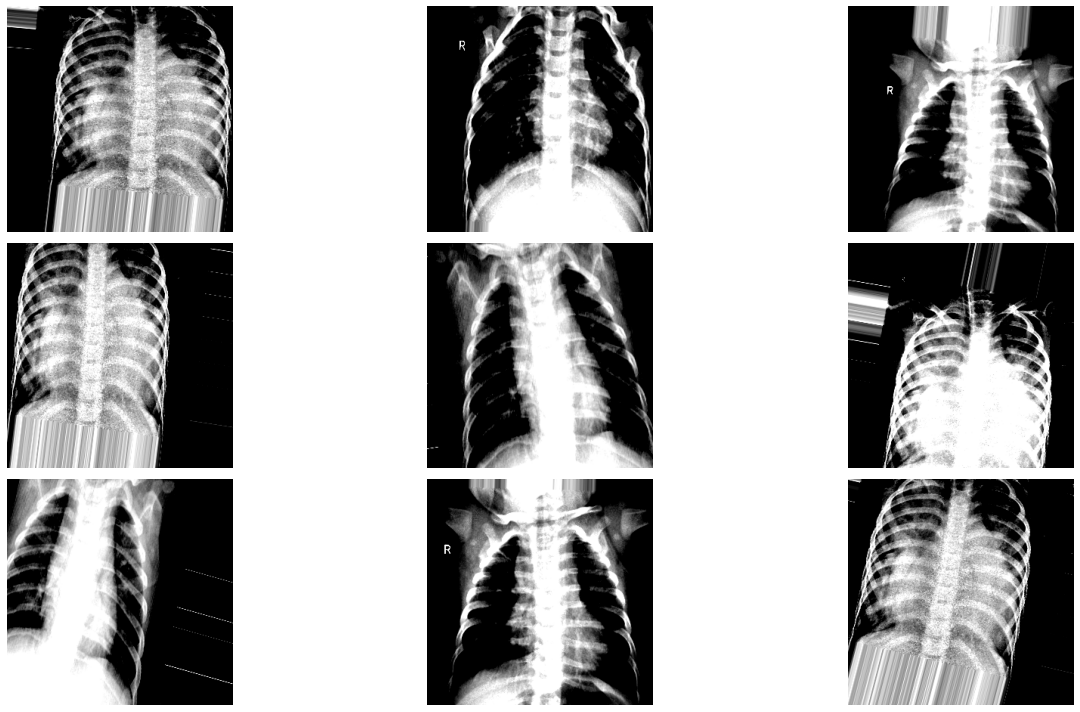

In [27]:
# Displays 9 generated train_generator images 

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

for i in range(9):
    num = random.randint(0,3)
    plt.subplot(3,3, i + 1)
    
    x,y = train_generator.__getitem__(num)
    
    plt.imshow(x[num],cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

In [28]:
# create the base pre-trained model

input_shape = [299,299]

base_model = Xception (input_shape = input_shape+[3], weights = 'imagenet', include_top = False)

x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(1024, kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)

# and a logistic layer
out = Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=out)

In [29]:
# set learning rate scheduler

def scheduler(epoch):
    if epoch < 15:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

# set early stopping

stopping = EarlyStopping(monitor='val_loss', patience=6)

In [30]:
#compile the model

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()                   

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [31]:
start_time = time.time()

In [32]:
callbacks = ModelCheckpoint('Xception_xray.h5', monitor='val_loss', verbose=1, save_best_only=True, mode = 'auto')

batch_size = 4

r = model.fit(train_generator, validation_data=(test_generator), 
                        steps_per_epoch = X_train.shape[0]//batch_size, epochs= 50, 
                        callbacks = [callbacks,lr_schedule,stopping, tensorboard])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1638 steps, validate for 286 steps
Epoch 1/50
1637/1638 [============================>.] - ETA: 0s - loss: 7.5383 - accuracy: 0.7227
Epoch 00001: val_loss improved from inf to 1.81236, saving model to Xception_xray.h5
1638/1638 [==============================] - 187s 114ms/step - loss: 7.5348 - accuracy: 0.7228 - val_loss: 1.8124 - val_accuracy: 0.8047
Epoch 2/50
1637/1638 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.8073
Epoch 00002: val_loss improved from 1.81236 to 0.70524, saving model to Xception_xray.h5
1638/1638 [==============================] - 182s 111ms/step - loss: 1.0383 - accuracy: 0.8072 - val_loss: 0.7052 - val_accuracy: 0.8126
Epoch 3/50
1637/1638 [============================>.] - ETA: 0s - loss: 0.5469 - accuracy: 0.8358
Epoch 00003: val_loss improved from 0.70524 to 0.57807, saving model to Xception_xray.h5
1638/1638 [==============================] - 185s 113ms/step - loss: 0.546

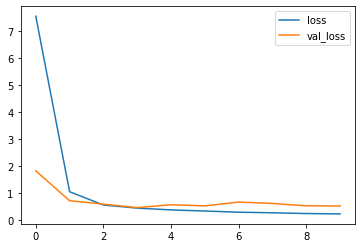

In [33]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

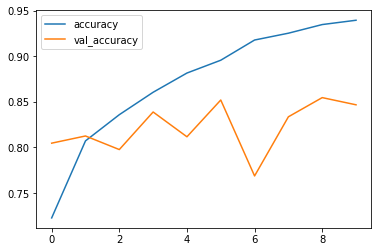

In [34]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [35]:
final_model = tf.keras.models.load_model('Xception_xray.h5')

([<matplotlib.axis.YTick at 0x25637c12b08>,
 [Text(0, 0, '1_Normal'), Text(0, 1, '2_Bacteria'), Text(0, 2, '3_Virus')])

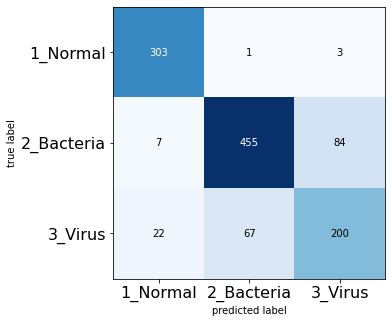

In [36]:
P_test= final_model.predict(test_generator, steps=len(test_generator)).argmax(axis=1)

matrix1 = confusion_matrix (y_test, P_test)
plot_confusion_matrix(matrix1, figsize=(5,5))
plt.xticks(range(3), ['1_Normal','2_Bacteria','3_Virus'], fontsize=16)
plt.yticks(range(3), ['1_Normal','2_Bacteria', '3_Virus'], fontsize=16)

In [37]:
def perf_measure(y_holdout, P):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(P)): 
        if y_holdout[i]==P[i]==1:
           TP += 1
        if y_holdout[i]==1 and y_holdout[i]!=P[i]:
           FN += 1
        if y_holdout[i]==P[i]==0:
           TN += 1
        if y_holdout[i]==0 and y_holdout[i]!=P[i]:
           FP += 1

    return(TP, FP, TN, FN)

In [38]:
tp, fp, tn ,fn = perf_measure(y_test,P_test)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

Recall of the model is 0.83
Precision of the model is 0.99
F-Score is 0.91


([<matplotlib.axis.YTick at 0x2563b690708>,
 [Text(0, 0, '1_Normal'), Text(0, 1, '2_Bacteria'), Text(0, 2, '3_Virus')])

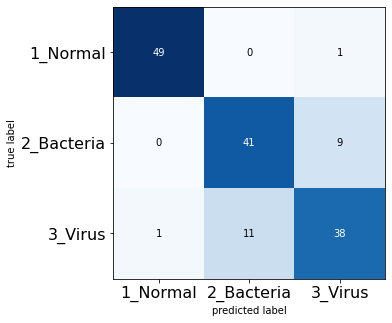

In [39]:
P_val= final_model.predict(valid_generator, steps=len(valid_generator)).argmax(axis=1)

matrix = confusion_matrix (y_val, P_val)
plot_confusion_matrix(matrix, figsize=(5,5))
plt.xticks(range(3), ['1_Normal','2_Bacteria','3_Virus'], fontsize=16)
plt.yticks(range(3), ['1_Normal','2_Bacteria', '3_Virus'], fontsize=16)

In [40]:
tp, fp, tn ,fn = perf_measure(y_val,P_val)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

Recall of the model is 0.82
Precision of the model is 0.98
F-Score is 0.89


In [41]:
tp, fp, tn ,fn = perf_measure(y_val==0,P_val==0)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of Normal is {:.2f}".format(recall*100))
print("Precision of Normal is {:.2f}".format(precision*100))
print("F-Score of Normal is {:.2f}".format(f_score*100))

tp, fp, tn ,fn = perf_measure(y_val==1,P_val==1)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of Bacterial Pneumonia is {:.2f}".format(recall*100))
print("Precision of Bacterial Pneumonia is {:.2f}".format(precision*100))
print("F-Score of Bacterial Pneumonia is {:.2f}".format(f_score*100))

tp, fp, tn ,fn = perf_measure(y_val==2,P_val==2)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of Viral Pneumonia is {:.2f}".format(recall*100))
print("Precision of Viral Pneumonia is {:.2f}".format(precision*100))
print("F-Score of Viral Pneumonia is {:.2f}".format(f_score*100))

Recall of Normal is 98.00
Precision of Normal is 98.00
F-Score of Normal is 98.00
Recall of Bacterial Pneumonia is 82.00
Precision of Bacterial Pneumonia is 78.85
F-Score of Bacterial Pneumonia is 80.39
Recall of Viral Pneumonia is 76.00
Precision of Viral Pneumonia is 79.17
F-Score of Viral Pneumonia is 77.55


In [42]:
end_time= time.time()

print("--- %s seconds ---" % (end_time - start_time))

--- 2578.704316139221 seconds ---


In [ ]:
xls_actual =[]
xls_preds = []
confidence_percentage = []

plt.figure(figsize=(20,120))

for i in range(val.shape[0]):
    
    plt.subplot(30,5, i + 1)
    plt.imshow(val[i][0], cmap='gray')
    actual = labels[val[i][1]]
    plt.xlabel(f'Actual - {actual}')
    
    if actual == '1_NORMAL':
        xls_actual.append('Normal')
    elif actual == '2_BACTERIA':
        xls_actual.append('Bacteria')
    else:
        xls_actual.append('Virus')

    P1= final_model.predict(valid_generator,steps =len(valid_generator)).argmax(axis =1)
    
    if P1[i] == 0:
        plt.ylabel('Predicted - Normal')
        xls_preds.append('Normal')
    elif P1[i] == 1:
        plt.ylabel('Predicted - Bacteria')
        xls_preds.append('Bacteria')
    else:
        plt.ylabel('Predicted - Virus')
        xls_preds.append('Virus')
    
    P2= final_model.predict(valid_generator,steps =len(valid_generator))
    conf = np.amax(P2[i])*100
    conf_decimal = float("{:.2f}".format(conf))
    confidence_percentage.append(conf_decimal)
    
plt.savefig('pneumonia_predictions_hand_designed.pdf')
        
pairs = {'Actuals': xls_actual, 'Predictions': xls_preds, 'Confidence_of_Prediction': confidence_percentage}

df = pd.DataFrame.from_dict(pairs)

df.to_csv('Predictions_Pneumonia_hand_designed.csv')